In [1]:
# 필요한 라이브러리 설치
!pip install pandas scikit-learn lifelines matplotlib seaborn scikit-survival

In [2]:
!pip install lifelines

In [3]:
# 데이터와 분석에 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

!sudo apt-get install -y fonts-nanum    # Nanum 폰트 설치
!sudo fc-cache -fv                     # 폰트 캐시를 강제로 갱신
!rm -rf ~/.cache/matplotlib            # Matplotlib 캐시 삭제

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') # 'Malgun Gothic' 대신 'NanumBarunGothic' 사용
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_path = '/content/drive/MyDrive/baf_society/data_with_dummies_2.csv'
data = pd.read_csv(data_path)
data.head(), data.columns

(      총면적  폐업여부  총 영업일  고가프차 개수_500m  저가프차 개수_500m  중가프차 개수_500m  카페 개수_500m  \
 0   17.36     1     88             0             0             0           0   
 1   89.10     0   5381             0             0             0           0   
 2  390.88     0   5381             0             0             0           0   
 3   53.30     1    700             0             0             0           0   
 4    6.60     1    133             0             0             0           0   
 
    음식점 개수_500m  bank_500m 개수  middle_500m 개수  ...  hospital_re_500m 개수  \
 0          286             1               2  ...                    0   
 1          185             1               1  ...                    0   
 2          670             4               0  ...                    0   
 3         1508             1               0  ...                    0   
 4          294            11               3  ...                    0   
 
    subway_250m 존재여부  hospital_big_1000m 개수   생활인구 점수  월 임대료

In [6]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 것을 방지

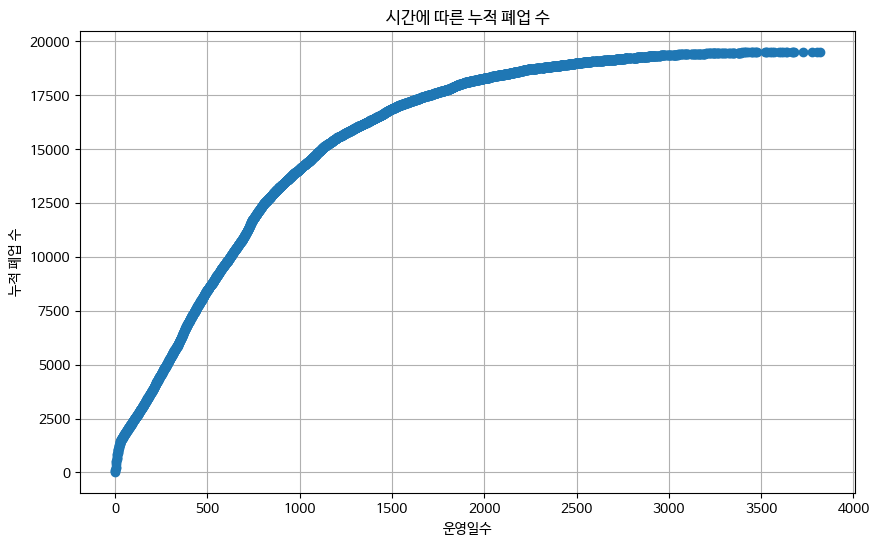

In [9]:
# 폐업 이벤트 발생 시간 계산 (예시로 '총 영업일'을 사용)
events = data[data['폐업여부'] == 1]['총 영업일']

# 이벤트 발생 빈도 계산
event_counts = events.value_counts().sort_index().cumsum()

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(event_counts.index, event_counts.values, marker='o', linestyle='-')
plt.title('시간에 따른 누적 폐업 수')
plt.xlabel('운영일수')
plt.ylabel('누적 폐업 수')
plt.grid(True)
plt.show()

### Random Survival Forests
- 폐업여부를 단일 종속 변수로 고려

- 단순 RandomForestClassifier 확인



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 타깃 변수 설정
y = data['폐업여부']

# 특성 데이터 설정
X = data.drop('폐업여부', axis=1)

# boolean columns to integer
X = X.astype(int)

# 데이터를 훈련 세트와 테스트 세트로 분할 (훈련 70%, 테스트 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 분류기 생성 및 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 세트의 결과 예측
y_pred = rf_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep


(0.9299127399650959,
 '              precision    recall  f1-score   support\n\n           0       0.92      0.97      0.94      8429\n           1       0.95      0.88      0.91      5896\n\n    accuracy                           0.93     14325\n   macro avg       0.93      0.92      0.93     14325\nweighted avg       0.93      0.93      0.93     14325\n')

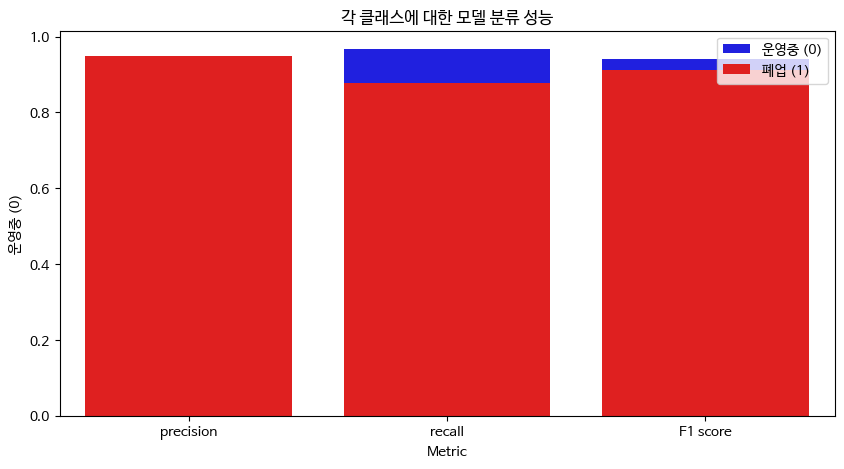

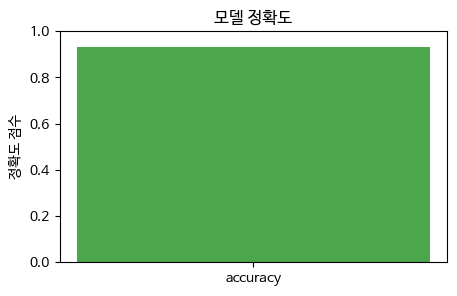

In [11]:
# 모델 평가
accuracy = accuracy_score(y_test, y_pred)  # 정확도 계산
classification_rep = classification_report(y_test, y_pred, output_dict=True)  # 분류 보고서 생성

# 데이터 프레임 생성
metrics_df = pd.DataFrame({
    'Metric': ['precision', 'recall', 'F1 score'],
    '운영중 (0)': [classification_rep['0']['precision'], classification_rep['0']['recall'], classification_rep['0']['f1-score']],
    '폐업 (1)': [classification_rep['1']['precision'], classification_rep['1']['recall'], classification_rep['1']['f1-score']]
})

# 막대 그래프로 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Metric', y='운영중 (0)', color='blue', label='운영중 (0)')
sns.barplot(data=metrics_df, x='Metric', y='폐업 (1)', color='red', label='폐업 (1)')
plt.title('각 클래스에 대한 모델 분류 성능')
plt.legend()
plt.show()

# 정확도 시각화
plt.figure(figsize=(5, 3))
plt.bar('accuracy', accuracy, color='green', alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('정확도 점수')
plt.title('모델 정확도')
plt.show()


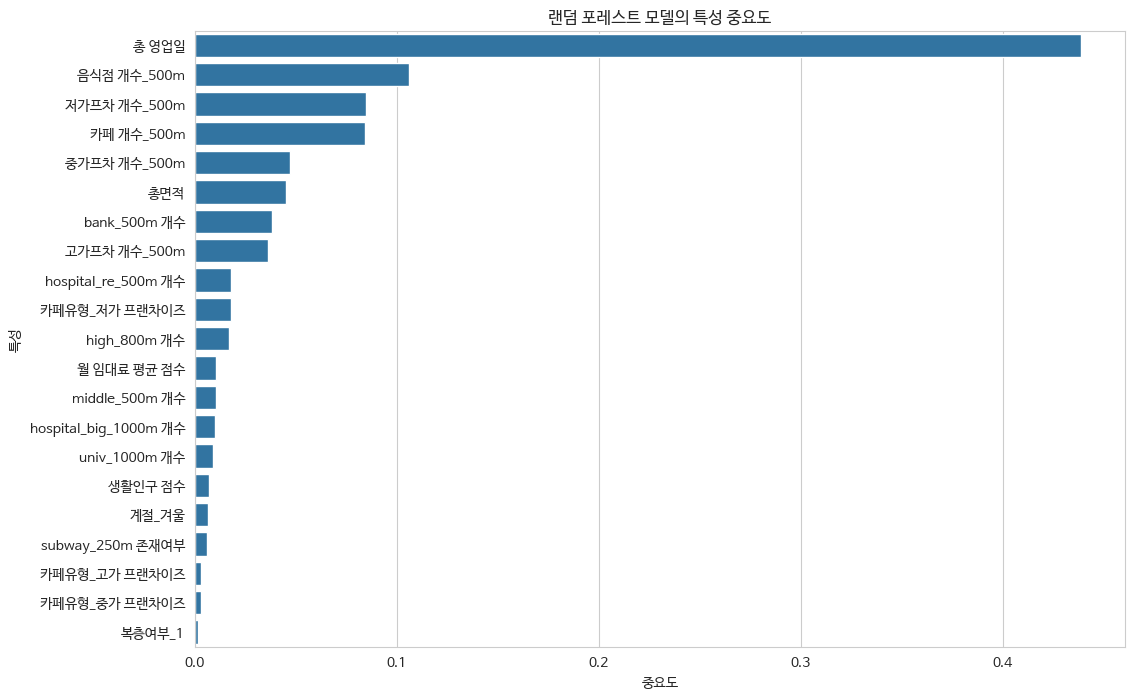

In [12]:
# plot style
sns.set_style("whitegrid")
plt.rc('font', family='NanumBarunGothic')

# 랜덤 포레스트 모델로부터 특성 중요도 가져오기
feature_importances = rf_model.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# 중요도에 따라 특성 정렬
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('랜덤 포레스트 모델의 특성 중요도')  # 그래프 제목
plt.xlabel('중요도')  # x축 레이블
plt.ylabel('특성')  # y축 레이블
plt.show()


## 랜덤 서바이벌 모델로만 예측 가능한가요?

- 랜덤 서바이벌 모델 사용

In [43]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 생존 분석용 데이터 준비 (타겟 변수를 생존 분석 형태로 변환)
y_survival = np.array([(bool(v), d) for v, d in zip(data['폐업여부'], data['총 영업일'])],
                      dtype=[('event', '?'), ('time', '<f8')])

# 특성 데이터 설정 및 원-핫 인코딩 적용
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_survival, test_size=0.3, random_state=42)

# 랜덤 서바이벌 포레스트 생성 및 학습
rsf_model = RandomSurvivalForest(n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
rsf_model.fit(X_train, y_train)

RandomSurvivalForest(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                     n_estimators=50, random_state=42)

#### 콩코드 지수 : 예측된 위험과 실제 생존 시간 사이의 일치도 측정
- 0~1 사이 값 가지고, 1에 가까울 수록 모델의 예측 성능이 높음을 의미

In [14]:
# C-index 계산
c_index = rsf_model.score(X_test, y_test)
print(f"C-index: {c_index:.4f}")


C-index: 0.6650


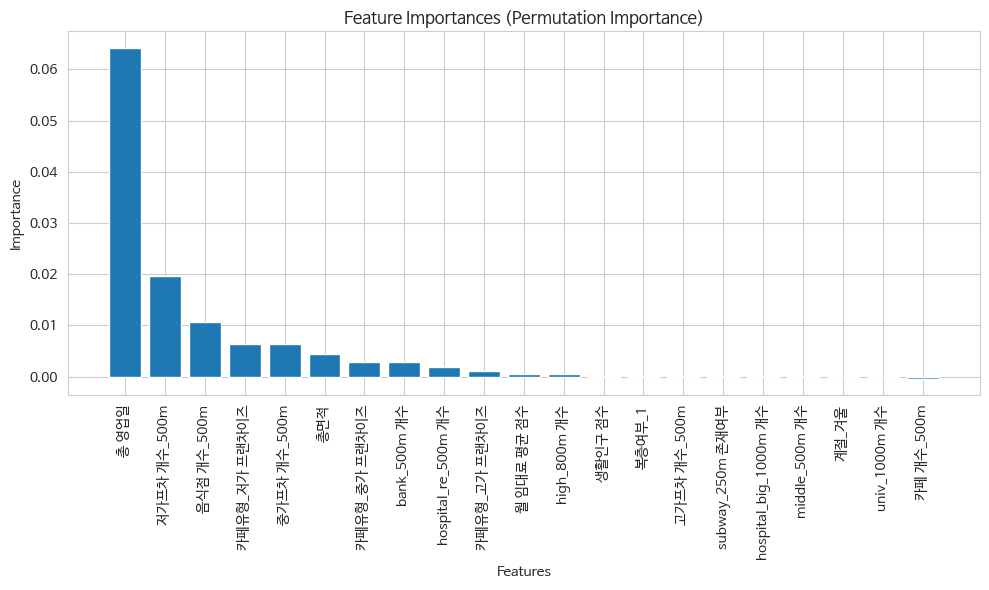

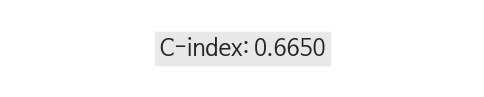

In [20]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# 퍼뮤테이션 중요도 계산
result = permutation_importance(rsf_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)

# 중요도 및 표준편차 가져오기
importances = result.importances_mean
std = result.importances_std

# 변수 이름 설정
feature_names = encoder.feature_names_in_

# 중요도 시각화
plt.figure(figsize=(10, 6))
indices = np.argsort(importances)[::-1]  # 중요도에 따라 내림차순 정렬
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Permutation Importance)')
plt.tight_layout()
plt.show()

# C-index 계산 및 시각화
c_index = rsf_model.score(X_test, y_test)
plt.figure(figsize=(6, 1))
plt.text(0.5, 0.5, f'C-index: {c_index:.4f}', horizontalalignment='center', verticalalignment='center',
         fontsize=16, bbox=dict(facecolor='lightgrey', alpha=0.5))
plt.axis('off')
plt.show()


### 네 그럼요
- 홍호와 자리에 고가 프랜차이즈 카페를 세울 경우

In [16]:
# 새로운 데이터 준비
new_data_high = pd.DataFrame({
    '총면적': [57.85],
    '고가프차 개수_500m': [6],
    '저가프차 개수_500m': [2],
    '중가프차 개수_500m': [3],
    '카페 개수_500m': [113],
    '음식점 개수_500m': [895],
    'bank_500m 개수': [7],
    'middle_500m 개수': [1],
    'high_800m 개수': [0],
    'univ_1000m 개수': [1],
    'hospital_re_500m 개수': [0],
    'subway_250m 존재여부': [0],
    'hospital_big_1000m 개수': [1],
    '생활인구 점수': [1.732320888],
    '월 임대료 평균 점수': [1.522459082],
    '복층여부_1': [0],
    '카페유형_고가 프랜차이즈': [1],
    '카페유형_저가 프랜차이즈': [0],
    '카페유형_중가 프랜차이즈': [0],
    '계절_겨울': [1]
})

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
# 하지만 새로운 데이터를 위한 인코딩 전에 훈련 데이터와 동일한 열을 갖도록 보장
new_data_high = new_data_high.reindex(columns=X.columns, fill_value=0)

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
new_data_high_encoded = encoder.transform(new_data_high)

# 새로운 데이터에 대해 생존 함수 예측 수행
pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# 예측된 폐업 여부 및 총 영업일 출력
# 특정 시점에서 생존 확률을 추정 (예: 1년, 2년, 1000일, 1500일 시점)
for fn in pred_survival_function:
    survival_prob_365 = fn(365)
    survival_prob_730 = fn(730)
    survival_prob_1000 = fn(1000)
    survival_prob_1500 = fn(1500)
    predicted_result = {
        "High-priced Franchise": {
            "폐업 여부 (730일)": "폐업" if survival_prob_730 < 0.5 else "생존",
            # "총 영업일 예측 (730일)": survival_prob_730 * 730,
            "생존 확률 (365일)": survival_prob_365,
            "생존 확률 (730일)": survival_prob_730,
            "생존 확률 (1000일)": survival_prob_1000,
            "생존 확률 (1500일)": survival_prob_1500
        }
    }

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부 (730일): {value['폐업 여부 (730일)']}")
    # print(f" - 총 영업일 예측 (730일): {value['총 영업일 예측 (730일)']:.2f}일")
    print(f" - 생존 확률 (365일): {value['생존 확률 (365일)']:.2f}")
    print(f" - 생존 확률 (730일): {value['생존 확률 (730일)']:.2f}")
    print(f" - 생존 확률 (1000일): {value['생존 확률 (1000일)']:.2f}")
    print(f" - 생존 확률 (1500일): {value['생존 확률 (1500일)']:.2f}")


Prediction for High-priced Franchise:
 - 폐업 여부 (730일): 폐업
 - 생존 확률 (365일): 0.35
 - 생존 확률 (730일): 0.31
 - 생존 확률 (1000일): 0.30
 - 생존 확률 (1500일): 0.28


- 홍호와 자리에 저가 프랜차이즈 카페를 차릴경우

In [13]:
# 새로운 데이터 준비
new_data_high = pd.DataFrame({
    '총면적': [57.85],
    '고가프차 개수_500m': [6],
    '저가프차 개수_500m': [2],
    '중가프차 개수_500m': [3],
    '카페 개수_500m': [113],
    '음식점 개수_500m': [895],
    'bank_500m 개수': [7],
    'middle_500m 개수': [1],
    'high_800m 개수': [0],
    'univ_1000m 개수': [1],
    'hospital_re_500m 개수': [0],
    'subway_250m 존재여부': [0],
    'hospital_big_1000m 개수': [1],
    '생활인구 점수': [1.732320888],
    '월 임대료 평균 점수': [1.522459082],
    '복층여부_1': [0],
    '카페유형_고가 프랜차이즈': [0],
    '카페유형_저가 프랜차이즈': [1],
    '카페유형_중가 프랜차이즈': [0],
    '계절_겨울': [1]
})

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
# 하지만 새로운 데이터를 위한 인코딩 전에 훈련 데이터와 동일한 열을 갖도록 보장
new_data_high = new_data_high.reindex(columns=X.columns, fill_value=0)

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
new_data_high_encoded = encoder.transform(new_data_high)

# 새로운 데이터에 대해 생존 함수 예측 수행
pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# 예측된 폐업 여부 및 총 영업일 출력
# 특정 시점에서 생존 확률을 추정 (예: 1년, 2년, 1000일, 1500일 시점)
for fn in pred_survival_function:
    survival_prob_365 = fn(365)
    survival_prob_730 = fn(730)
    survival_prob_1000 = fn(1000)
    survival_prob_1500 = fn(1500)
    predicted_result = {
        "Low-priced Franchise": {
            "폐업 여부 (730일)": "폐업" if survival_prob_730 < 0.5 else "생존",
            # "총 영업일 예측 (730일)": survival_prob_730 * 730,
            "생존 확률 (365일)": survival_prob_365,
            "생존 확률 (730일)": survival_prob_730,
            "생존 확률 (1000일)": survival_prob_1000,
            "생존 확률 (1500일)": survival_prob_1500
        }
    }

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부 (730일): {value['폐업 여부 (730일)']}")
    # print(f" - 총 영업일 예측 (730일): {value['총 영업일 예측 (730일)']:.2f}일")
    print(f" - 생존 확률 (365일): {value['생존 확률 (365일)']:.2f}")
    print(f" - 생존 확률 (730일): {value['생존 확률 (730일)']:.2f}")
    print(f" - 생존 확률 (1000일): {value['생존 확률 (1000일)']:.2f}")
    print(f" - 생존 확률 (1500일): {value['생존 확률 (1500일)']:.2f}")


Prediction for Low-priced Franchise:
 - 폐업 여부 (730일): 폐업
 - 생존 확률 (365일): 0.31
 - 생존 확률 (730일): 0.27
 - 생존 확률 (1000일): 0.26
 - 생존 확률 (1500일): 0.26


- 중가 프랜차이즈 여부

In [14]:
# 새로운 데이터 준비
new_data_high = pd.DataFrame({
    '총면적': [57.85],
    '고가프차 개수_500m': [6],
    '저가프차 개수_500m': [2],
    '중가프차 개수_500m': [3],
    '카페 개수_500m': [113],
    '음식점 개수_500m': [895],
    'bank_500m 개수': [7],
    'middle_500m 개수': [1],
    'high_800m 개수': [0],
    'univ_1000m 개수': [1],
    'hospital_re_500m 개수': [0],
    'subway_250m 존재여부': [0],
    'hospital_big_1000m 개수': [1],
    '생활인구 점수': [1.732320888],
    '월 임대료 평균 점수': [1.522459082],
    '복층여부_1': [0],
    '카페유형_고가 프랜차이즈': [0],
    '카페유형_저가 프랜차이즈': [0],
    '카페유형_중가 프랜차이즈': [1],
    '계절_겨울': [1]
})

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
# 하지만 새로운 데이터를 위한 인코딩 전에 훈련 데이터와 동일한 열을 갖도록 보장
new_data_high = new_data_high.reindex(columns=X.columns, fill_value=0)

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
new_data_high_encoded = encoder.transform(new_data_high)

# 새로운 데이터에 대해 생존 함수 예측 수행
pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# 예측된 폐업 여부 및 총 영업일 출력
# 특정 시점에서 생존 확률을 추정 (예: 1년, 2년, 1000일, 1500일 시점)
for fn in pred_survival_function:
    survival_prob_365 = fn(365)
    survival_prob_730 = fn(730)
    survival_prob_1000 = fn(1000)
    survival_prob_1500 = fn(1500)
    predicted_result = {
        "Mid-priced Franchise": {
            "폐업 여부 (730일)": "폐업" if survival_prob_730 < 0.5 else "생존",
            # "총 영업일 예측 (730일)": survival_prob_730 * 730,
            "생존 확률 (365일)": survival_prob_365,
            "생존 확률 (730일)": survival_prob_730,
            "생존 확률 (1000일)": survival_prob_1000,
            "생존 확률 (1500일)": survival_prob_1500
        }
    }

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부 (730일): {value['폐업 여부 (730일)']}")
    # print(f" - 총 영업일 예측 (730일): {value['총 영업일 예측 (730일)']:.2f}일")
    print(f" - 생존 확률 (365일): {value['생존 확률 (365일)']:.2f}")
    print(f" - 생존 확률 (730일): {value['생존 확률 (730일)']:.2f}")
    print(f" - 생존 확률 (1000일): {value['생존 확률 (1000일)']:.2f}")
    print(f" - 생존 확률 (1500일): {value['생존 확률 (1500일)']:.2f}")


Prediction for Mid-priced Franchise:
 - 폐업 여부 (730일): 폐업
 - 생존 확률 (365일): 0.34
 - 생존 확률 (730일): 0.28
 - 생존 확률 (1000일): 0.27
 - 생존 확률 (1500일): 0.26


- 개인카페

In [15]:
# 새로운 데이터 준비 - 개인카페
new_data_high = pd.DataFrame({
    '총면적': [57.85],
    '고가프차 개수_500m': [6],
    '저가프차 개수_500m': [2],
    '중가프차 개수_500m': [3],
    '카페 개수_500m': [113],
    '음식점 개수_500m': [895],
    'bank_500m 개수': [7],
    'middle_500m 개수': [1],
    'high_800m 개수': [0],
    'univ_1000m 개수': [1],
    'hospital_re_500m 개수': [0],
    'subway_250m 존재여부': [0],
    'hospital_big_1000m 개수': [1],
    '생활인구 점수': [1.732320888],
    '월 임대료 평균 점수': [1.522459082],
    '복층여부_1': [0],
    '카페유형_고가 프랜차이즈': [0],
    '카페유형_저가 프랜차이즈': [0],
    '카페유형_중가 프랜차이즈': [0],
    '계절_겨울': [1]
})

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
# 하지만 새로운 데이터를 위한 인코딩 전에 훈련 데이터와 동일한 열을 갖도록 보장
new_data_high = new_data_high.reindex(columns=X.columns, fill_value=0)

# 새로운 데이터에 대해 훈련된 인코더를 사용하여 인코딩 수행
new_data_high_encoded = encoder.transform(new_data_high)

# 새로운 데이터에 대해 생존 함수 예측 수행
pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# 예측된 폐업 여부 및 총 영업일 출력
# 특정 시점에서 생존 확률을 추정 (예: 1년, 2년, 1000일, 1500일 시점)
for fn in pred_survival_function:
    survival_prob_365 = fn(365)
    survival_prob_730 = fn(730)
    survival_prob_1000 = fn(1000)
    survival_prob_1500 = fn(1500)
    predicted_result = {
        "non Franchise": {
            "폐업 여부 (730일)": "폐업" if survival_prob_730 < 0.5 else "생존",
            # "총 영업일 예측 (730일)": survival_prob_730 * 730,
            "생존 확률 (365일)": survival_prob_365,
            "생존 확률 (730일)": survival_prob_730,
            "생존 확률 (1000일)": survival_prob_1000,
            "생존 확률 (1500일)": survival_prob_1500
        }
    }

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부 (730일): {value['폐업 여부 (730일)']}")
    # print(f" - 총 영업일 예측 (730일): {value['총 영업일 예측 (730일)']:.2f}일")
    print(f" - 생존 확률 (365일): {value['생존 확률 (365일)']:.2f}")
    print(f" - 생존 확률 (730일): {value['생존 확률 (730일)']:.2f}")
    print(f" - 생존 확률 (1000일): {value['생존 확률 (1000일)']:.2f}")
    print(f" - 생존 확률 (1500일): {value['생존 확률 (1500일)']:.2f}")


Prediction for non Franchise:
 - 폐업 여부 (730일): 폐업
 - 생존 확률 (365일): 0.33
 - 생존 확률 (730일): 0.29
 - 생존 확률 (1000일): 0.27
 - 생존 확률 (1500일): 0.26


### 추가 모델 고려
- MultiOutputRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 및 준비
X = data.drop(['폐업여부', '총 영업일'], axis=1)
y = data[['폐업여부', '총 영업일']]

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 다중 출력 모델 생성 및 학습
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
# 각 종속 변수에 대한 평가 필요, 예를 들어 폐업 여부의 정확도, 총 영업일의 MSE 계산 등
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_percentage_error, confusion_matrix

# 폐업여부는 정수로 변환 후 평가
accuracy = accuracy_score(y_test['폐업여부'], np.round(y_pred[:, 0]))
mse = mean_squared_error(y_test['총 영업일'], y_pred[:, 1])
mape = mean_absolute_percentage_error(y_test['총 영업일'], y_pred[:, 1])
print("Accuracy for 폐업여부:", accuracy)
print("MSE for 총 영업일:", mse)
print("MAPE for 총 영업일:", mape)

Accuracy for 폐업여부: 0.7233507853403142
MSE for 총 영업일: 1142604.887764745
MAPE for 총 영업일: 4.6427629760028415


                  Feature  Importance
5             음식점 개수_500m    0.185891
0                     총면적    0.162051
4              카페 개수_500m    0.128546
2            저가프차 개수_500m    0.084181
14            월 임대료 평균 점수    0.075622
13                생활인구 점수    0.071490
6            bank_500m 개수    0.056441
3            중가프차 개수_500m    0.040514
10    hospital_re_500m 개수    0.033928
1            고가프차 개수_500m    0.032825
8            high_800m 개수    0.029966
7          middle_500m 개수    0.019158
12  hospital_big_1000m 개수    0.015790
9           univ_1000m 개수    0.015148
19                  계절_겨울    0.014520
11       subway_250m 존재여부    0.011687
17          카페유형_저가 프랜차이즈    0.008077
18          카페유형_중가 프랜차이즈    0.007028
16          카페유형_고가 프랜차이즈    0.004374
15                 복층여부_1    0.002764


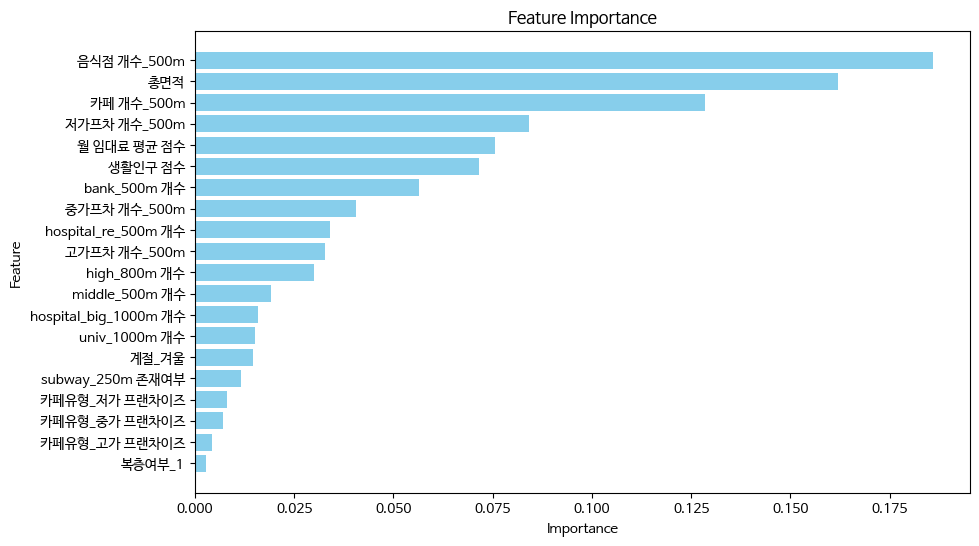

In [ ]:
# 변수 중요도 확인 및 시각화
feature_importances = model.estimators_[0].feature_importances_
features = X.columns

# 변수 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


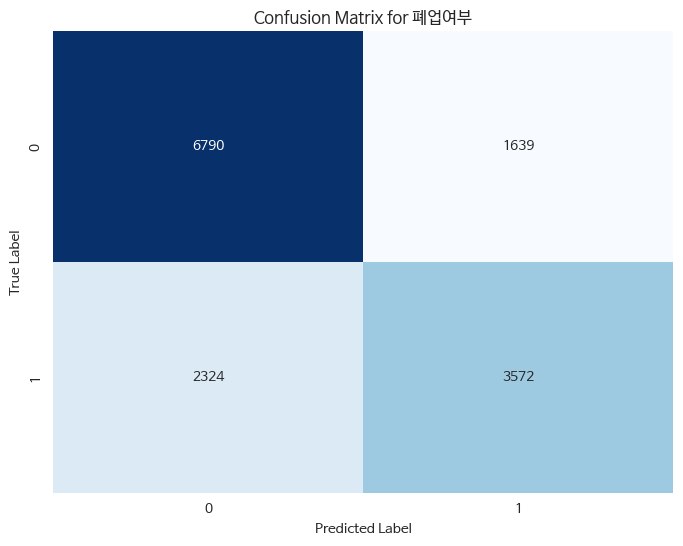

In [ ]:
# 혼동행렬 계산 및 시각화
conf_matrix = confusion_matrix(y_test['폐업여부'], np.round(y_pred[:, 0]))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 폐업여부')
plt.show()


In [ ]:
# # 정확도 및 MSE 시각화
# fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# accuracy = 0.7233507853403142
# mse = 1142604.887764745

# # 정확도 바 차트
# ax[0].bar('Accuracy', accuracy, color='blue')
# ax[0].set_title('Accuracy for 폐업여부')
# ax[0].set_ylim(0, 1)  # Accuracy limit
# ax[0].text('Accuracy', accuracy, f'{accuracy:.2f}', ha='center', va='bottom')

# # MSE 바 차트
# ax[1].bar('MSE', mse, color='red')
# ax[1].set_title('MSE for 총 영업일')
# ax[1].text('MSE', mse, f'{mse:.2f}', ha='center', va='bottom')

# plt.tight_layout()
# plt.show()



In [ ]:
# 새로운 데이터에 대해 모델을 사용하여 예측 수행 - 고가 프렌차이즈 여부
  new_data_high = pd.DataFrame({
      '총면적': [57.85] ,
      '고가프차 개수_500m' : [6],
      '저가프차 개수_500m' : [2],
      '중가프차 개수_500m' : [3],
      '카페 개수_500m' : [113],
      '음식점 개수_500m' : [895],
      'bank_500m 개수' : [7],
      'middle_500m 개수' : [1],
      'high_800m 개수' : [0],
      'univ_1000m 개수' : [1],
      'hospital_re_500m 개수' : [0],
      'subway_250m 존재여부' : [0],
      'hospital_big_1000m 개수' : [1],
      '생활인구 점수' : [1.732320888],
      '월 임대료 평균 점수' : [1.522459082],
      '복층여부_1' : [0],
      '카페유형_고가 프랜차이즈' : [1],
      '카페유형_저가 프랜차이즈' : [0],
      '카페유형_중가 프랜차이즈' : [0],
      '계절_겨울' : [1]
  })

# 예측 수행
pred_high = model.predict(new_data_high)

# 예측된 폐업 여부 (0: 생존, 1: 폐업)와 총 영업일 출력
predicted_result = {
    "High-priced Franchise": {
        "폐업 여부": "폐업" if round(pred_high[0][0]) == 1 else "생존",
        "총 영업일 예측": pred_high[0][1]
    }
}

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부: {value['폐업 여부']}")
    print(f" - 총 영업일 예측: {value['총 영업일 예측']:.2f}일")


Prediction for High-priced Franchise:
 - 폐업 여부: 생존
 - 총 영업일 예측: 765.08일


In [ ]:
# # 개별 트리의 예측값 수집
# individual_predictions = [tree.predict(new_data_high)[0] for tree in model.estimators_[0].estimators_]

# # 예측 평균 및 표준편차 계산
# mean_prediction = np.mean(individual_predictions)
# std_prediction = np.std(individual_predictions)

# print(f"개별 트리 예측의 평균: {mean_prediction:.2f}일")
# print(f"개별 트리 예측의 표준편차: {std_prediction:.2f}일")

# # 765일 동안 운영될 확률 추정
# # 정규 분포를 가정하고 예측값이 평균에서 얼마나 떨어져 있는지 평가
# from scipy.stats import norm

# probability = norm.cdf(765, loc=mean_prediction, scale=std_prediction)
# print(f"765일 동안 운영될 확률: {probability * 100:.2f}%")


- 파라미터 조절 필수, 리소스 과부하옴

In [ ]:
# from sksurv.ensemble import RandomSurvivalForest
# from sksurv.preprocessing import OneHotEncoder

# # 생존 분석용 데이터 준비 (타겟 변수를 생존 분석 형태로 변환)
# y_survival = np.array([(bool(v), d) for v, d in zip(data['폐업여부'], data['총 영업일'])],
#                       dtype=[('event', '?'), ('time', '<f8')])

# # 특성 데이터 설정 및 원-핫 인코딩 적용
# X_encoded = OneHotEncoder().fit_transform(X)

# # 데이터를 훈련 세트와 테스트 세트로 분할
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_survival, test_size=0.3, random_state=42)

# # 랜덤 서바이벌 포레스트 생성 및 학습
# rsf_model = RandomSurvivalForest(n_estimators=100, random_state=42)
# rsf_model.fit(X_train, y_train)

# # 새로운 데이터에 대해 생존 확률 예측
# pred_survival_prob = rsf_model.predict_survival_function(new_data_high, return_array=True)

# # 765일 동안 생존할 확률 확인 (765일 지점에서 생존 확률)
# survival_prob_765_days = pred_survival_prob[0][np.where(rsf_model.event_times_ == 765)[0][0]]
# print(f"765일 동안 생존할 확률: {survival_prob_765_days:.2f}")


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 생존 분석용 데이터 준비 (타겟 변수를 생존 분석 형태로 변환)
y_survival = np.array([(bool(v), d) for v, d in zip(data['폐업여부'], data['총 영업일'])],
                      dtype=[('event', '?'), ('time', '<f8')])

# 특성 데이터 설정 및 원-핫 인코딩 적용
X_encoded = OneHotEncoder().fit_transform(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_survival, test_size=0.3, random_state=42)

# 랜덤 서바이벌 포레스트 생성 및 학습
rsf_model = RandomSurvivalForest(n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
rsf_model.fit(X_train, y_train)

RandomSurvivalForest(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                     n_estimators=50, random_state=42)

In [ ]:
# # 새로운 데이터 준비 (new_data_high와 동일한 특성 형식이어야 함)
# new_data_high_encoded = OneHotEncoder().fit_transform(new_data_high)

# # 새로운 데이터에 대해 생존 확률 예측
# pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# # 765일 동안 생존할 확률 확인
# # 생존 함수에서 765일에 해당하는 생존 확률을 추정
# for fn in pred_survival_function:
#     survival_prob_765_days = fn(765)
#     print(f"765일 동안 생존할 확률: {survival_prob_765_days:.2f}")

In [ ]:
# 새로운 데이터 준비 (new_data_high와 동일한 특성 형식이어야 함)
new_data_low_encoded = OneHotEncoder().fit_transform(new_data_high)

# 새로운 데이터에 대해 생존 확률 예측
pred_survival_function = rsf_model.predict_survival_function(new_data_low_encoded)

# 716일 동안 생존할 확률 확인
# 생존 함수에서 716일에 해당하는 생존 확률을 추정
for fn in pred_survival_function:
    survival_prob_716_days = fn(716)
    print(f"716일 동안 생존할 확률: {survival_prob_716_days:.2f}")

716일 동안 생존할 확률: 0.91


In [ ]:
# 새로운 데이터에 대해 모델을 사용하여 예측 수행 - 중가 프렌차이즈 여부
new_data_high = pd.DataFrame({
    '총면적': [57.85] ,
    '고가프차 개수_500m' : [6],
    '저가프차 개수_500m' : [2],
    '중가프차 개수_500m' : [3],
    '카페 개수_500m' : [113],
    '음식점 개수_500m' : [895],
    'bank_500m 개수' : [7],
    'middle_500m 개수' : [1],
    'high_800m 개수' : [0],
    'univ_1000m 개수' : [1],
    'hospital_re_500m 개수' : [0],
    'subway_250m 존재여부' : [0],
    'hospital_big_1000m 개수' : [1],
    '생활인구 점수' : [1.732320888],
    '월 임대료 평균 점수' : [1.522459082],
    '복층여부_1' : [0],
    '카페유형_고가 프랜차이즈' : [0],
    '카페유형_저가 프랜차이즈' : [0],
    '카페유형_중가 프랜차이즈' : [1],
    '계절_겨울' : [1]
})

# 예측 수행
pred_high = model.predict(new_data_high)

# 예측된 폐업 여부 (0: 생존, 1: 폐업)와 총 영업일 출력
predicted_result = {
    "Mid-priced Franchise": {
        "폐업 여부": "폐업" if round(pred_high[0][0]) == 1 else "생존",
        "총 영업일 예측": pred_high[0][1]
    }
}

# 예측 결과 출력
for key, value in predicted_result.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부: {value['폐업 여부']}")
    print(f" - 총 영업일 예측: {value['총 영업일 예측']:.2f}일")


Prediction for Mid-priced Franchise:
 - 폐업 여부: 생존
 - 총 영업일 예측: 700.48일


In [ ]:
# 새로운 데이터 준비 (new_data_high와 동일한 특성 형식이어야 함)
new_data_mid_encoded = OneHotEncoder().fit_transform(new_data_high)

# 새로운 데이터에 대해 생존 확률 예측
pred_survival_function = rsf_model.predict_survival_function(new_data_mid_encoded)

# 700일 동안 생존할 확률 확인
# 생존 함수에서 700일에 해당하는 생존 확률을 추정
for fn in pred_survival_function:
    survival_prob_700_days = fn(700)
    print(f"700일 동안 생존할 확률: {survival_prob_700_days:.2f}")

700일 동안 생존할 확률: 0.83


In [ ]:
# 1000일동안 생존할 확률
new_data_high_encoded = OneHotEncoder().fit_transform(new_data_high)

# 새로운 데이터에 대해 생존 확률 예측
pred_survival_function = rsf_model.predict_survival_function(new_data_high_encoded)

# 1000일 동안 생존할 확률 확인
# 생존 함수에서 1000일에 해당하는 생존 확률을 추정
for fn in pred_survival_function:
    survival_prob_1000_days = fn(1000)
    print(f"1000일 동안 생존할 확률: {survival_prob_1000_days:.2f}")

1000일 동안 생존할 확률: 0.77


In [ ]:
# 새로운 데이터 준비 - 저가 프렌차이즈 여부 (위치 관련 정보 포함)
new_data_low = pd.DataFrame({
    '총면적': [57.85],
    '고가프차 개수_500m': [6],
    '저가프차 개수_500m': [2],
    '중가프차 개수_500m': [3],
    '카페 개수_500m': [113],
    '음식점 개수_500m': [895],
    'bank_500m 개수': [7],
    'middle_500m 개수': [1],
    'high_800m 개수': [0],
    'univ_1000m 개수': [1],
    'hospital_re_500m 개수': [0],
    'subway_250m 존재여부': [0],
    'hospital_big_1000m 개수': [1],
    '생활인구 점수': [1.732320888],
    '월 임대료 평균 점수': [1.522459082],
    '복층여부_1': [0],
    '카페유형_고가 프랜차이즈': [0],
    '카페유형_저가 프랜차이즈': [1],
    '카페유형_중가 프랜차이즈': [0],
    '계절_겨울': [1]
})

# 새로운 데이터에 대해 원-핫 인코딩 수행
new_data_low_encoded = OneHotEncoder().fit_transform(new_data_low)

# 생존 함수 예측
pred_survival_function_low = rsf_model.predict_survival_function(new_data_low_encoded)

# 특정 시점 (예: 1000일)에서의 생존 확률 확인
for fn in pred_survival_function_low:
    survival_prob_1000_days = fn(1000)
    predicted_result_low = {
        "Low-priced Franchise": {
            "폐업 여부": "폐업" if survival_prob_1000_days < 0.5 else "생존",
            "총 영업일 예측": survival_prob_1000_days * 1000 , # 예측된 생존 확률과 기간을 활용한 예측값
            "생존 확률": survival_prob_1000_days
        }
    }

# 예측 결과 출력
for key, value in predicted_result_low.items():
    print(f"Prediction for {key}:")
    print(f" - 폐업 여부: {value['폐업 여부']}")
    print(f" - 총 영업일 예측: {value['총 영업일 예측']:.2f}일")
    print(f" - 생존 확률: {value['생존 확률']:.2f}")


- 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# 타깃 변수 설정 (폐업여부와 총 영업일)
y = data[['폐업여부', '총 영업일']]

# 특성 데이터 설정
X = data.drop(['폐업여부', '총 영업일'], axis=1)

# 부울린 칼럼을 정수형으로 변환
X = X.astype(int)

# 데이터를 훈련 세트와 테스트 세트로 분할 (훈련 70%, 테스트 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],  # 트리 개수 범위 축소
    'max_depth': [None, 10, 20],  # 최대 깊이 범위 축소
    'min_samples_split': [2, 5],  # 분할 최소 샘플 개수 축소
    'min_samples_leaf': [1, 2],  # 리프 최소 샘플 개수 축소
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=10,  # 시도할 하이퍼파라미터 조합의 개수 감소
    cv=2,  # 교차 검증 횟수 감소
    verbose=2,
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 하이퍼파라미터 튜닝 수행 (훈련 데이터에 대해 학습)
random_search.fit(X_train, y_train['총 영업일'])

# 최적의 파라미터와 점수 출력
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
Best Score: 0.2128065084869485


In [ ]:
# 최적의 파라미터로 모델 다시 학습
best_params = random_search.best_params_
optimized_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# 모델 학습
optimized_rf.fit(X_train, y_train['총 영업일'])

# 테스트 데이터에 대한 예측
y_pred_optimized = optimized_rf.predict(X_test)

# 성능 평가
mse_optimized = mean_squared_error(y_test['총 영업일'], y_pred_optimized)
print("Optimized MSE for 총 영업일:", mse_optimized)


Optimized MSE for 총 영업일: 1169415.2464101384


### Gradient Boosting



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Gradient Boosting 모델 생성 및 학습
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gb_model.fit(X_train, y_train)

# 새로운 데이터에 대해 예측 수행
pred_high_gb = gb_model.predict(new_data_high)

# 예측된 폐업 여부 및 총 영업일 출력 (Gradient Boosting)
predicted_result_gb = {
    "High-priced Franchise (Gradient Boosting)": {
        "폐업 여부": "폐업" if round(pred_high_gb[0][0]) == 1 else "생존",
        "총 영업일 예측": pred_high_gb[0][1]
    }
}

print("Gradient Boosting Prediction for High-priced Franchise:")
print(f" - 폐업 여부: {predicted_result_gb['High-priced Franchise (Gradient Boosting)']['폐업 여부']}")
print(f" - 총 영업일 예측: {predicted_result_gb['High-priced Franchise (Gradient Boosting)']['총 영업일 예측']:.2f}일")


Gradient Boosting Prediction for High-priced Franchise:
 - 폐업 여부: 생존
 - 총 영업일 예측: 1092.82일


### XGBoost

In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# XGBoost 모델 생성 및 학습
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
xgb_model.fit(X_train, y_train)

# 새로운 데이터에 대해 예측 수행
pred_high_xgb = xgb_model.predict(new_data_high)

# 예측된 폐업 여부 및 총 영업일 출력 (XGBoost)
predicted_result_xgb = {
    "High-priced Franchise (XGBoost)": {
        "폐업 여부": "폐업" if round(pred_high_xgb[0][0]) == 1 else "생존",
        "총 영업일 예측": pred_high_xgb[0][1]
    }
}

print("XGBoost Prediction for High-priced Franchise:")
print(f" - 폐업 여부: {predicted_result_xgb['High-priced Franchise (XGBoost)']['폐업 여부']}")
print(f" - 총 영업일 예측: {predicted_result_xgb['High-priced Franchise (XGBoost)']['총 영업일 예측']:.2f}일")


XGBoost Prediction for High-priced Franchise:
 - 폐업 여부: 생존
 - 총 영업일 예측: 763.61일


In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_percentage_error

# Gradient Boosting 성능 평가
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test['폐업여부'], np.round(y_pred_gb[:, 0]))
mse_gb = mean_squared_error(y_test['총 영업일'], y_pred_gb[:, 1])
mape_gb = mean_absolute_percentage_error(y_test['총 영업일'], y_pred_gb[:, 1])

print("\nGradient Boosting Model Performance:")
print(f"Accuracy for 폐업여부: {accuracy_gb:.2f}")
print(f"MSE for 총 영업일: {mse_gb:.2f}")
print(f"MAPE for 총 영업일: {mape_gb:.2f}")

# XGBoost 성능 평가
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test['폐업여부'], np.round(y_pred_xgb[:, 0]))
mse_xgb = mean_squared_error(y_test['총 영업일'], y_pred_xgb[:, 1])
mape_xgb = mean_absolute_percentage_error(y_test['총 영업일'], y_pred_xgb[:, 1])

print("\nXGBoost Model Performance:")
print(f"Accuracy for 폐업여부: {accuracy_xgb:.2f}")
print(f"MSE for 총 영업일: {mse_xgb:.2f}")
print(f"MAPE for 총 영업일: {mape_xgb:.2f}")



Gradient Boosting Model Performance:
Accuracy for 폐업여부: 0.71
MSE for 총 영업일: 1198801.76
MAPE for 총 영업일: 5.90

XGBoost Model Performance:
Accuracy for 폐업여부: 0.72
MSE for 총 영업일: 1187749.64
MAPE for 총 영업일: 4.90
